In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [3]:
# pairwise distances between all points
D = pairwise_distances(X)
# K-nearest neighbors distances for each point (by row)
KNN = np.sort(D,axis=1)
# K-nearest neighbor indices for each points (by row)
KNN_indices = np.argsort(D,axis=1)

In [4]:
# Get the k-nearest neighbor for object p
def k_distance(p,k):
    return KNN[p][1:][k]

In [5]:
# Get all objects o within k_distance of object p
def N_k_distance(p,k_distance):
    idx = np.where(KNN[p]<=k_distance)[0][1:]
    return KNN_indices[p][idx]

In [6]:
# get the reach_dist of object p wrt object o (the maximum gives a smooth factor to the distances, reduce statistical fluctation)
def reach_dist_k(p,o,k):
    return np.max([k_distance(o,k),D[p,o]])

In [7]:
# local reachability density of object p (smaller is more spread out points, larger is tight cluster of points)
def lrd_k(p,k):
    N_MinPts = N_k_distance(p,k_distance(p,k))
    
    return 1 / (np.sum([reach_dist_k(p,o,k) for o in N_MinPts])/len(N_MinPts))

In [8]:
# local outlier factor (determine degree of outliernish) of object p 
# value < 1 means similar density as neighbors (probably inlier, maybe not)
# value ~= 1 means similar density as outliers (inliers)
# value > 1 means lower density than neighbors (outliers)
def LOF_k(p,k):
    N_MinPts = N_k_distance(p,k_distance(p,k))
    
    lrd_p = lrd_k(p,k)
    
    return (np.sum([lrd_k(o,k)/lrd_p for o in N_MinPts]))/len(N_MinPts)

In [9]:
X_scores = []
for i in range(len(X)):
    X_scores.append(LOF_k(i,20))
X_scores = np.array(X_scores)

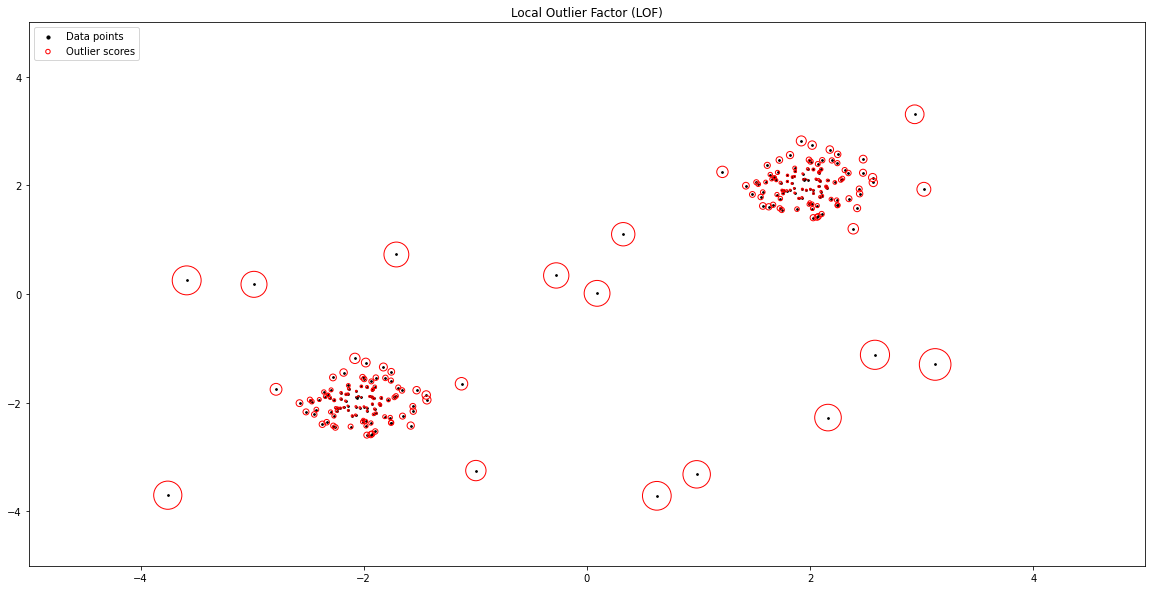

In [12]:
plt.figure(figsize=(20,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores - X_scores.min()) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

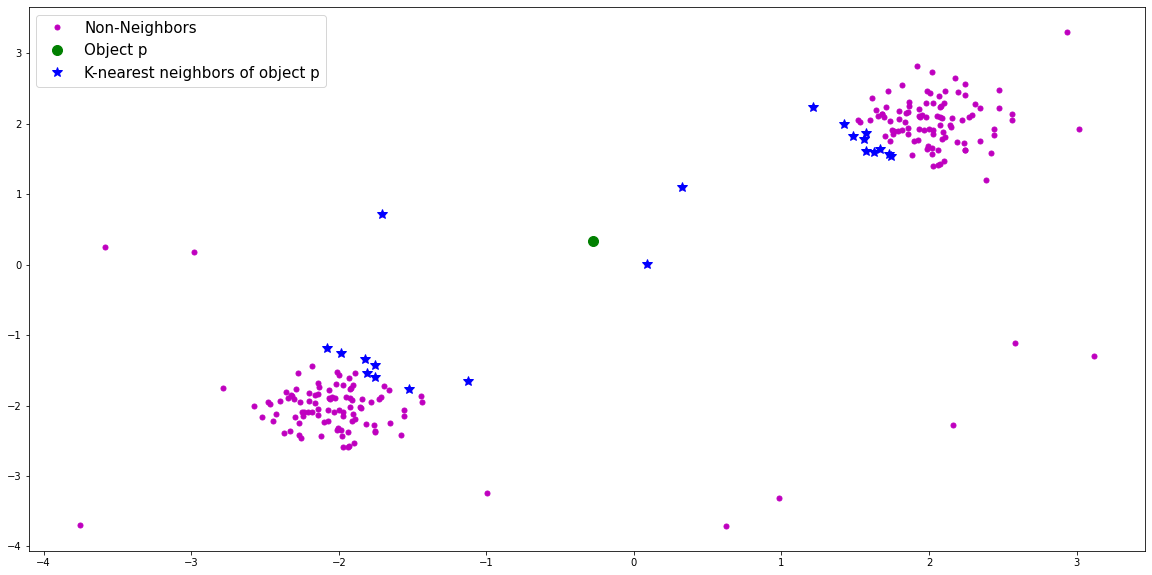

In [34]:
# plot example of analysis...
p_ind = 211
N_MinPts_p = N_k_distance(p_ind,k_distance(p_ind,20))
X_neighbors = X[N_MinPts_p]
p = X[p_ind]

plt.figure(figsize=(20,10))
plt.plot(X[:,0],X[:,1],'m.',markersize=10)
plt.plot(p[0],p[1],'go',markersize=10)
plt.plot(X_neighbors[:,0],X_neighbors[:,1],'b*',markersize=10)
plt.legend(["Non-Neighbors","Object p","K-nearest neighbors of object p"],fontsize=15)
plt.show()